# A/B тесты

## Задание 1. 
У нас есть данные АА-теста с '2022-07-06' по '2022-07-12'. Вам нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

4. Пришлите ссылку на merge request c проведенным анализом.

In [1]:
# библиотеки
import pandas as pd
import numpy as np 
import scipy.stats as stats
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy.stats import ttest_ind
from tqdm import tqdm
from yaml import load, FullLoader

In [2]:
# стили
plt.style.use('dark_background')

In [3]:
config = load(open('config_ab.yaml'), Loader=FullLoader)

connection = {
    'host': config['ab tests']['host'],
    'database':'simulator_20220820',
    'user':'student', 
    'password': config['ab tests']['password']
}

In [4]:
def select(query):
    return ph.read_clickhouse(query, connection=connection)

def df_info(data):
    table_info = (
        pd.DataFrame(
            {
                'column_type':data.dtypes,
                'row_count':data.count(),
                'unique_count':data.nunique(),
                'duplicated_count':data.duplicated().sum(),
                'duplicated_pct':data.duplicated().mean(),
                'nan_count':data.isna().sum(),
                'nan_pct':data.isna().mean(),
                'min':data.min(),
                'max':data.max(),
                'mean':data.mean(numeric_only=True)
            }
        )
        .sort_values(by='nan_count',ascending=False)
        .style.format(
            {
                'unique_pct': '{:.1%}',
                'duplicated_pct': '{:.1%}',
                'nan_pct': '{:.1%}',
            }
        )
    )
    return display(table_info)

In [5]:
query = '''
    SELECT exp_group,
           user_id,
           sum(action = 'like') as likes,
           sum(action = 'view') as views,
           likes/views as ctr
    FROM {db}.feed_actions
    WHERE toDate(time) BETWEEN '2022-07-06' AND '2022-07-12' AND exp_group IN (2,3)
    GROUP BY exp_group, user_id
'''

In [6]:
df = select(query)

In [7]:
df_info(df)

,column_type,row_count,unique_count,duplicated_count,duplicated_pct,nan_count,nan_pct,min,max,mean
exp_group,int8,17049,2,0,0.0%,0,0.0%,2.000000,3.000000,2.502610
user_id,uint32,17049,17049,0,0.0%,0,0.0%,200.000000,133642.000000,69403.161476
likes,uint64,17049,79,0,0.0%,0,0.0%,0.000000,83.000000,15.573699
views,uint64,17049,293,0,0.0%,0,0.0%,1.000000,369.000000,73.797349
ctr,float64,17049,2422,0,0.0%,0,0.0%,0.000000,0.714286,0.218706


In [8]:
df.exp_group.value_counts().to_frame()

,exp_group
3,8569
2,8480


группы примерно одинакового размера

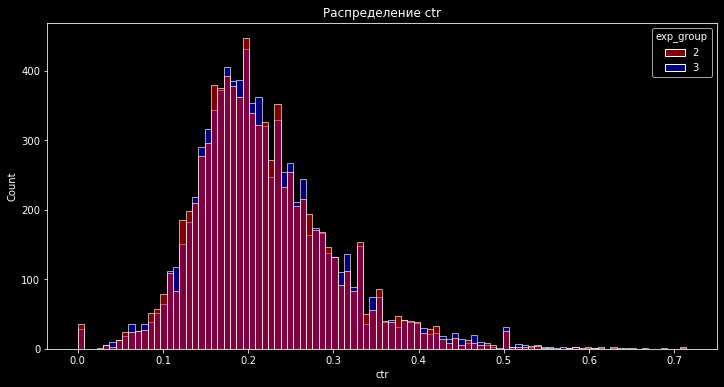

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(
    data=df,
    x='ctr',
    hue='exp_group',
    palette=['r','b'],
    alpha=0.5
)
ax.set_title('Распределение ctr')
plt.show()

Для t-testa не требуется нормальность распределения, требуется нормальность среднего распределения. Cогласно ЦПТ случайные выборочные средние будут стремиться к нормальному распределению.

100%|███████████████████████████████████| 10000/10000 [00:03<00:00, 3158.87it/s]


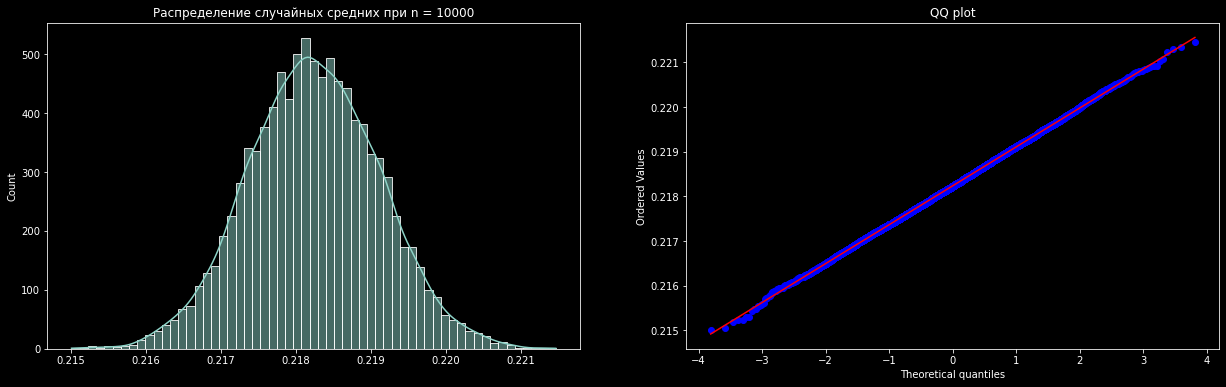

In [10]:
a = df.query('exp_group == 2')['ctr']
n = 10000
a_a = pd.Series([a.sample(len(a),replace=True).mean() for _ in tqdm(range(n))])

fig, axes = plt.subplots(1,2, figsize=(21, 6))
sns.histplot(a_a,kde=True,ax=axes[0])
axes[0].set_title(f'Распределение случайных средних при n = {n}')

stats.probplot(a_a, dist="norm",plot=axes[1])
axes[1].set_title('QQ plot')
plt.show()

На гистограмме видно, что случайные средние имеют нормальное распределение. С помощью **QQ-plot** проверяем, нормально ли распределены случайные средние значения (красная линия совпадает с синими точками).

Мы берем подвыборки с размерностью 500, без возвращения в корзину, т.е. изъятые значения уникальны, повторения значений для каждого юзера в данной подвыборке не будет, т.к. мы проводим ttest, то для сравнения подвыборок обязательно условие независимости таких значений, т.е. не должно быть повторений в подвыборке.
Проводим для каждой такой подвыборки между группами 2 и 3 **ttest** со следующей гипотезой:  
  
**H0:** средний ctr группы A $=$ средний ctr группы B  
**H1:**  средний ctr группы A $\not=$ средний ctr группы B
  
На выходе получаем pvalue, в нашем случае количество таких экспериментов равно 10000

In [11]:
b_n = 10000
subsample_size = 500

pval = [ttest_ind(
    df.query('exp_group == 2').ctr.sample(subsample_size,replace=False),
    df.query('exp_group == 3').ctr.sample(subsample_size,replace=False),
    equal_var=False
).pvalue for _ in tqdm(range(b_n))]
pval = pd.Series(pval)

100%|████████████████████████████████████| 10000/10000 [00:29<00:00, 335.59it/s]


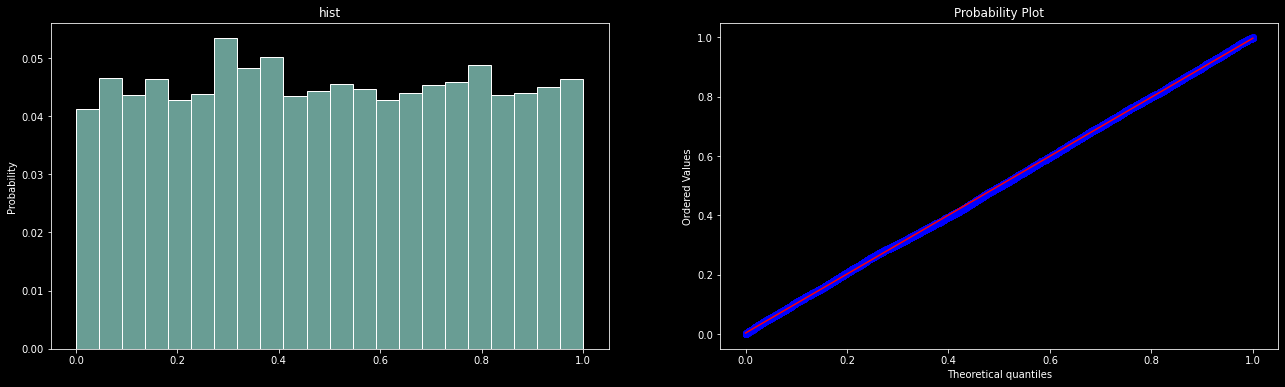

In [12]:
fig, axes = plt.subplots(1,2, figsize=(22, 6))
sns.histplot(pval,stat='probability',ax=axes[0])
stats.probplot(pval, dist="uniform",plot=axes[1])
axes[0].set_title('hist')
plt.show()

На гистограмме распределение выглядит равномерно(все столбцы примерно одинаковой высоты), чтобы убедиться в этом можно построить probability plot (красная линия совпадает с синими точками).

In [13]:
print('В {:.2%} случаев нам удалось отклонить нулевую гипотезу'.format((pval < 0.05).mean()))

В 4.59% случаев нам удалось отклонить нулевую гипотезу


### Вывод:

АА тест проводится для проверки искажений метрики (выбросы, дисперсия) и проверки сплитования групп. В результате случайного ложного срабатывания, приблизительно в 5% получаются статистические значимые различия между группами (A $\not=$ B), наша система сплитования работает корректно.  
Метрика ctr подходит для использования в AB эксперименте.

---

## Задание 2. 

Задача — проанализировать данные АB-теста. 

1.Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).  
2.Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали?   
3.Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.  
4.Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

In [14]:
# сглаженный ctr
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

def mannwhitneyu(A,B,alpha=.05):
    m_result = stats.mannwhitneyu(A,B,alternative='two-sided')
    print(f'pvalue: {m_result.pvalue}')
    if m_result.pvalue < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не получилось отвергнуть нулевую гипотезу') 
        
def ttest(A,B,alpha=.05):
    t_result = ttest_ind(A,B,equal_var=False)
    print(f'pvalue: {t_result.pvalue}')
    if t_result.pvalue < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не получилось отвергнуть нулевую гипотезу') 

def bootstrap(grp1,grp2,n_bootstrap=2000):
    likes_1 = grp1.likes.to_numpy()
    likes_2 = grp2.likes.to_numpy()
    views_1 = grp1.views.to_numpy()
    views_2 = grp2.views.to_numpy()
    
    weights_1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes_1))).astype(np.int64)
    weights_2 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes_2))).astype(np.int64) 
    
    globalCTR_1 = (likes_1 * weights_1).sum(axis=1)/(views_1 * weights_1).sum(axis=1)
    globalCTR_2 = (likes_2 * weights_2).sum(axis=1)/(views_2 * weights_2).sum(axis=1)
    return globalCTR_1, globalCTR_2

In [15]:
query = '''
    SELECT exp_group,
           user_id,
           sum(action = 'like') as likes,
           sum(action = 'view') as views,
           likes/views as ctr
    FROM {db}.feed_actions
    WHERE toDate(time) BETWEEN '2022-07-13' AND '2022-07-19' AND exp_group IN (1,2)
    GROUP BY exp_group, user_id
'''

In [16]:
df = select(query)

In [17]:
df_info(df)

,column_type,row_count,unique_count,duplicated_count,duplicated_pct,nan_count,nan_pct,min,max,mean
exp_group,int8,20031,2,0,0.0%,0,0.0%,1.000000,2.000000,1.496830
user_id,uint32,20031,20031,0,0.0%,0,0.0%,206.000000,141164.000000,75343.140432
likes,uint64,20031,84,0,0.0%,0,0.0%,0.000000,95.000000,13.448954
views,uint64,20031,280,0,0.0%,0,0.0%,1.000000,321.000000,66.224652
ctr,float64,20031,2782,0,0.0%,0,0.0%,0.000000,0.923077,0.215016


In [18]:
df.exp_group.value_counts().to_frame()

,exp_group
1,10079
2,9952


In [19]:
A_sample = df[df['exp_group'] == 2].copy()
B_sample = df[df['exp_group'] == 1].copy()

A_sample['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], A_sample.ctr.sum(), 5), axis=1)
B_sample['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], B_sample.ctr.sum(), 5), axis=1)

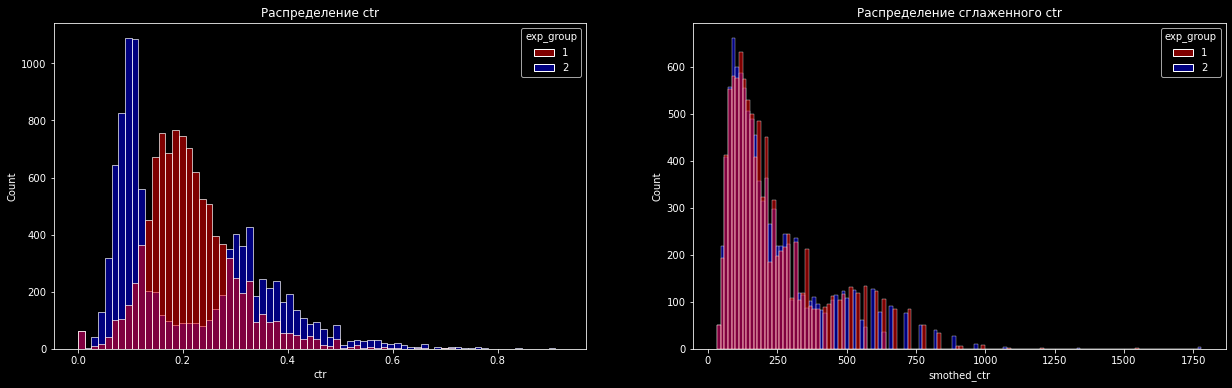

In [20]:
fig, ax = plt.subplots(1,2, figsize=(21, 6))
sns.histplot(
    data=df,
    x='ctr',
    hue='exp_group',
    palette=['r','b'],
    alpha=0.5,
    ax=ax[0])
sns.histplot(
    data=pd.concat([A_sample, B_sample]),
    x='smothed_ctr',
    hue='exp_group',
    palette=['r','b'],
    alpha=0.5,
    ax=ax[1])
ax[0].set_title('Распределение ctr')
ax[1].set_title('Распределение сглаженного ctr')
plt.show()

распределения ctr двух групп различны

In [21]:
data = {
    'A_mean': A_sample.ctr.mean(),
    'B_mean': B_sample.ctr.mean(),
    'A_std': np.std(A_sample.ctr,ddof=1),
    'B_std': np.std(B_sample.ctr,ddof=1)
}
pd.Series(data).to_frame().T

,A_mean,B_mean,A_std,B_std
0,0.214419,0.215605,0.14418,0.08416


Средние значения метрики ctr для двух групп похожи, вряд ли ttest заметит различия 

### ttest

Сформулируем нулевую и альтернативную гипотезы:  
**H0** - CTR нового алгоритма во 2-й группе $=$ CTR старого алгоритма в 1-й группе  
**H1** - CTR нового алгоритма во 2-й группе $>$ CTR старого алгоритма в 1-й группе  

Уровень значимости $\alpha = 0.05$

In [22]:
# для ctr
ttest(A_sample.ctr,B_sample.ctr)

pvalue: 0.4780623130874935
Не получилось отвергнуть нулевую гипотезу


In [23]:
# для сглаженного ctr
ttest(A_sample.smothed_ctr,B_sample.smothed_ctr)

pvalue: 0.4476506334224234
Не получилось отвергнуть нулевую гипотезу


ttest не отвергает нулевую гипотезу, т.е. различий нет, но распределения ctr двух групп различны

### тест Манна-уитни

In [24]:
mannwhitneyu(A_sample.ctr,B_sample.ctr)

pvalue: 6.0376484617779035e-56
Отвергаем нулевую гипотезу


Манн-уитни видит различия в группах

### бутстреп

In [25]:
ctr_1, ctr_2 = bootstrap(A_sample,B_sample)

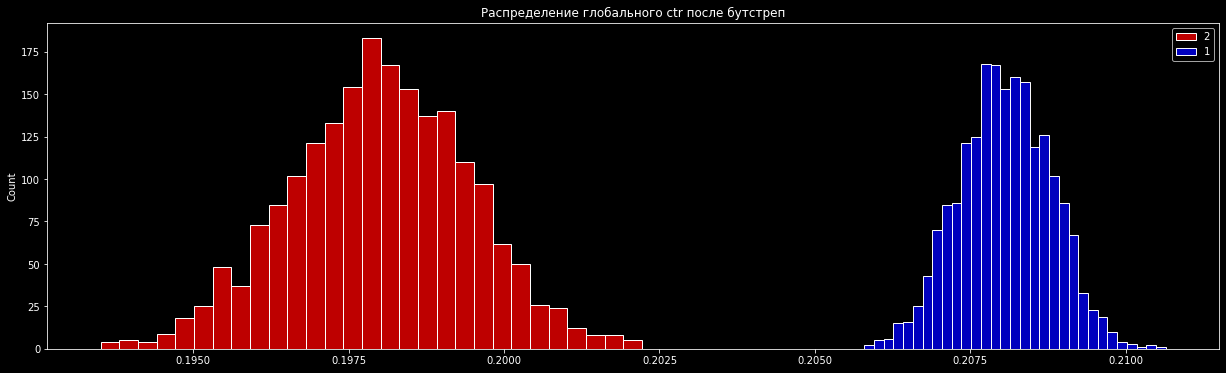

In [26]:
fig = plt.subplots(figsize=(21, 6))
sns.histplot(ctr_1,color='r', label='2')
sns.histplot(ctr_2,color='b', label='1')
plt.title('Распределение глобального ctr после бутстреп')
plt.legend()
plt.show()

значения группы 2(новый алгоритм) и 1 даже не пересекаются, глобальный ctr группы 1 значительно лучше, чем группы 2

### бакеты

In [27]:
query = """
    SELECT exp_group,
           xxHash64(user_id)%50 as bucket,
           sum(action = 'like') as likes,
           sum(action = 'view') as views,
           likes/views as ctr
    FROM {db}.feed_actions
    WHERE toDate(time) BETWEEN '2022-07-13' AND '2022-07-19' AND exp_group IN (1,2)
    GROUP BY exp_group, bucket
"""

In [28]:
buckets_df = select(query)
buckets_df.head()

,exp_group,bucket,likes,views,ctr
0,1,0,2624,13355,0.196481
1,2,0,2634,13559,0.194262
2,1,1,2681,12653,0.211887
3,2,1,2686,12474,0.215328
4,1,2,3046,14767,0.206271


In [29]:
A_sample_b = buckets_df[buckets_df['exp_group'] == 2].copy()
B_sample_b = buckets_df[buckets_df['exp_group'] == 1].copy()

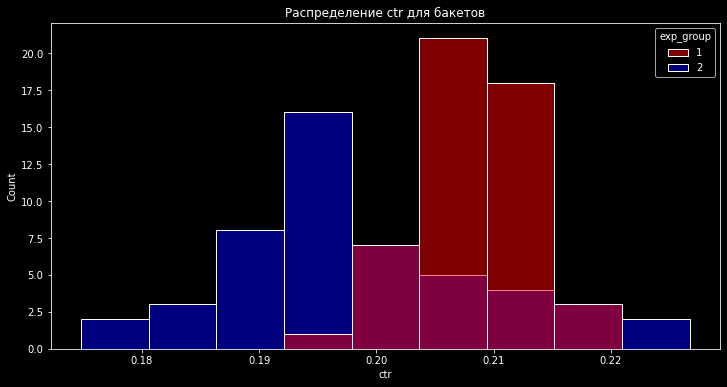

In [30]:
fig = plt.subplots(1, figsize=(12,6))
sns.histplot(data=buckets_df, x='ctr', hue='exp_group', palette=['r', 'b'])
plt.title('Распределение ctr для бакетов')
plt.show()

In [31]:
mannwhitneyu(A_sample_b.ctr,B_sample_b.ctr)

pvalue: 2.859963936492646e-07
Отвергаем нулевую гипотезу


In [32]:
ttest(A_sample_b.ctr,B_sample_b.ctr)

pvalue: 3.4455951649945907e-07
Отвергаем нулевую гипотезу


### Вывод:

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR.  
По итогам A/B тестов:
* бустреп показал, что значения CTR для нового алгоритма значительно хуже значений CTR старого алгоритма
* бакетное преобразование показало, что ctr для нового алгоритма хуже старого алгоритма, а тест манна-уитни и ттест видит различия  

Распределение ctr в новом алгоритме условно разделилось на два полюса, где часть значений CTR для юзеров стала хуже и часть значений стала лучше. Возможно алгоритм недостаточно обучен, что он помечает неверно целевые посты, следует проанализорвать алгоритм и выяснить почему часть значений имеет более лучший результат по метрике ctr, а часть значений стала хуже. На данный момент не рекомендуется использовать новый алгоритм на всех пользователей.

---

## Задание 3. 

**Задача**  
Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?  
Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

In [33]:
def hist(data):
    x = 'linearized_likes'
    sns.histplot(
    data=data,
    x=x,
    hue='exp_group',
    palette=['r','b'],
    alpha=0.5
).set_title(f'Распределение {x}')

### Группы 0 и 3

**H0**: group 1 $=$ group 2  
**H1**: group 1 $\not=$ group 2

In [34]:
query = '''
    SELECT exp_group,
           user_id,
           sum(action = 'like') as likes,
           sum(action = 'view') as views,
           likes/views as ctr
    FROM {db}.feed_actions
    WHERE toDate(time) BETWEEN '2022-07-13' AND '2022-07-19' AND exp_group IN (0,3)
    GROUP BY exp_group, user_id
'''

In [35]:
df = select(query)

In [36]:
ctr_control = df.query('exp_group == 0').likes.sum() / df.query('exp_group == 0').views.sum()
df['linearized_likes'] = df.likes - ctr_control * df.views
A_grp = df.query('exp_group == 0')
B_grp = df.query('exp_group == 3')

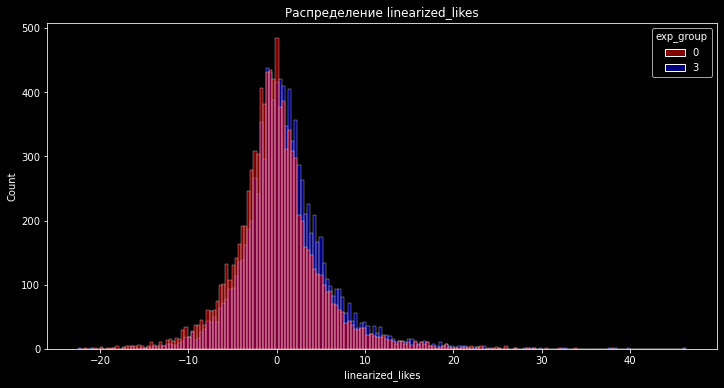

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))
hist(df)
plt.show()

In [38]:
ttest(A_grp.ctr,B_grp.ctr)

pvalue: 1.055849414662529e-43
Отвергаем нулевую гипотезу


In [39]:
ttest(A_grp.linearized_likes,B_grp.linearized_likes)

pvalue: 5.4914249479687664e-52
Отвергаем нулевую гипотезу


в данных группах ттест видит различия между ними

### Группы 1 и 2

**H0**: group 1 $=$ group 2  
**H1**: group 1 $\not=$ group 2

In [40]:
query = '''
    SELECT exp_group,
           user_id,
           sum(action = 'like') as likes,
           sum(action = 'view') as views,
           likes/views as ctr
    FROM {db}.feed_actions
    WHERE toDate(time) BETWEEN '2022-07-13' AND '2022-07-19' AND exp_group IN (1,2)
    GROUP BY exp_group, user_id
'''

In [41]:
df2 = select(query)

In [42]:
ctr_control = df2.query('exp_group == 1').likes.sum() / df2.query('exp_group == 1').views.sum()
df2['linearized_likes'] = df2.likes - ctr_control * df2.views
A_grp_1 = df2.query('exp_group == 1')
B_grp_2 = df2.query('exp_group == 2')

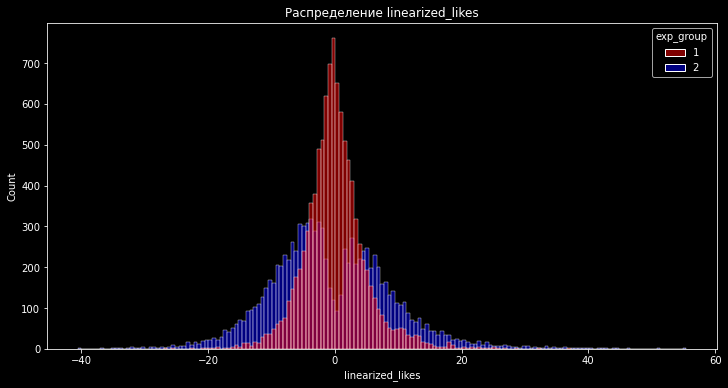

In [43]:
fig, ax = plt.subplots(figsize=(12, 6))
hist(df2)
plt.show()

распредение группы 2 стало более нормальным

In [44]:
ttest(A_grp_1.ctr,B_grp_2.ctr)

pvalue: 0.4780623130874935
Не получилось отвергнуть нулевую гипотезу


In [45]:
ttest(A_grp_1.linearized_likes,B_grp_2.linearized_likes)

pvalue: 9.439432187037712e-10
Отвергаем нулевую гипотезу


Линеаризованная метрика повысила чувствительность теста, что позволило увидить различия между группами.